# Table of Contents 
* [I. Introduction](#1)


* [II. Data Preparation](#2)
    * [A. Data](#2A)
    * [B. Importing and Preprocessing Corpus](#2B)
    * [C. Importing Labels](#2C)
    * [D. Preparing Negative Samples](#2D)
    

* [III. Training/Evaluating CEO Classifier](#3)
    * [A. Constructing Training Set](#3A)
        * [1. Extracting Positive Samples](#3A1)
        * [2. Extracting Negative Samples to Augment](#3A2)
        * [3. Building Features](#3A3)
    * [B. Training Logistic Regression Model](#3B)
    

* [IV. Training/Evaluating Company Classifier](#4)
    * [A. Constructing Training Set](#4A)
        * [1. Extracting Positive Samples](#4A1)
        * [2. Extracting Negative Samples to Augment](#4A2)
        * [3. Building Features](#4A3)
    * [B. Training Logistic Regression Model](#4B)
    


* [V. Training/Evaluating Percentage Classifier](#5)
    * [A. Constructing Training Set](#5A)
        * [1. Extracting Positive Samples](#5A1)
        * [2. Extracting Negative Samples to Augment](#5A2)
        * [3. Building Features](#5A3)
    * [B. Training Logistic Regression Model](#5B)
    

* [VI. Evaluation of Models](#6)
    * [A. CEO Classifier](#6A)
    * [B, Company Classifier](#6B)
    * [A. Percentage Classifier](#6C)
    

***

# I. Introduction <a class="anchor" id="1"></a>

The following document describes a step by step process of building text classifiers that parse through 730 articles on Business Insider and extracts entities in which it recognizes as one of three given types: CEOs, companies, and percentages. 

Based on provided label values for each of the three categories, a logistic regression model for each entity type was constructed to classify the words based the context of the sentence they are in. The CEO classifier, company classifier, and the percentage classifier models were run through a subset of entities from the corpus composing of all 730 articles. 

The goal of this project was to build the following models:
1.	**Classifier of names of CEOs in the corpus**
2.	**Classifier of company names in the corpus**
3.	**Classifier of entities involving percentages**

These models were 
- Trained on a set of positive samples (determined by provided label values) and subset of negative samples
- Evaluated on all entities extracted by `Spacy` 

The system parsed through a corpus of .txt files of total 730 Business Insider articles, taken from 2013 and 2014. The script is tailored to the format of these text files and will need to be adjusted if other articles are used. 

A general overview of the result of this analysis can be found on **BI Text Classification Overview.ipynb** in this repository.

***

# II. Data Preparation <a class="anchor" id="2"></a>

## A. Data <a class="anchor" id="2A"></a>

The data used includes 730 .txt files including Business Insider articles from 2013 to 2014. These will be processed and compiled as a text corpus. Sample file below:

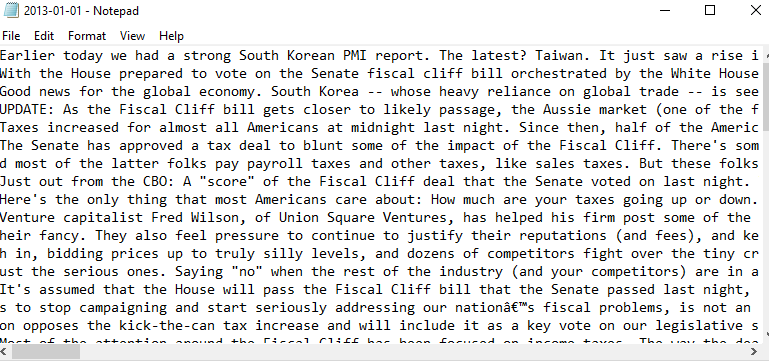

Data also includes the actual lists of CEOs/Company Names/Percentages existing in the entire Business Insider corpus, in .csv format. These will serve as labels to train the logistic regression classifiers on. 

## B. Importing and Preprocessing Corpus <a class="anchor" id="2B"></a>


Importing Packages 

In [3]:
import numpy as np
import pandas as pd
import re
import glob
import errno
import nltk
import spacy
import en_core_web_sm
import os
from nltk.tokenize import sent_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

Importing all of the Business Insider articles from 2013 to 2014 into a single string, cleaning it, and tokenizing it into sentences using the `nltk` package. 

In [2]:
paths = ["data/2013/*.txt", "data/2014/*.txt"]
corpus = []
for path in paths:
    files = glob.glob(path)
    for name in files:
        try:
            with open(name,encoding='utf8', errors='ignore') as f:
                corpus.extend(f.readlines())
        except IOError as exc: 
            if exc.errno != errno.EISDIR: 
                raise
corpus = ''.join(corpus)

corpus_cleaned = corpus.replace("\\","").replace("\n","").replace('\xa0', "") 
corpus_cleaned[:1000]

'Earlier today we had a strong South Korean PMI report. The latest? Taiwan. It just saw a rise in December PMI from 47.4 to 50.6. From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by the White House and Senate Minority Leader Mitch McConnell, conservatives are railing against GOP House Speaker John Boehner for caving on the deal. Here\'s the banner leading Drudge Report right now: Drudge ReportGood news for the global economy. South Korea -- whose heavy reliance on global trade -- is seen by some economists as the "canary in the coalmine" just came in with a strong PMI report. From the report: The HSBC South Korea Purchasing Managers’ IndexTM (PMI®) – a composite indicator designed to provide a single-figure snapshot of the health of the manufacturing sector – registered 50.1 in December. That was an improvement on November’s 48.2 and the highest reading since May. However, being barely above 50.0, the PMI suggested that operating conditions 

Tokenizing text into a list of sentences

In [3]:
sentences = nltk.sent_tokenize(corpus_cleaned)

First ten sentences from the list

In [4]:
sentences[:10] # sample of the list of sentences

['Earlier today we had a strong South Korean PMI report.',
 'The latest?',
 'Taiwan.',
 'It just saw a rise in December PMI from 47.4 to 50.6.',
 'From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by the White House and Senate Minority Leader Mitch McConnell, conservatives are railing against GOP House Speaker John Boehner for caving on the deal.',
 "Here's the banner leading Drudge Report right now: Drudge ReportGood news for the global economy.",
 'South Korea -- whose heavy reliance on global trade -- is seen by some economists as the "canary in the coalmine" just came in with a strong PMI report.',
 'From the report: The HSBC South Korea Purchasing Managers’ IndexTM (PMI®) – a composite indicator designed to provide a single-figure snapshot of the health of the manufacturing sector – registered 50.1 in December.',
 'That was an improvement on November’s 48.2 and the highest reading since May.',
 'However, being barely above 50.0, the PMI 

## C. Importing Labels <a class="anchor" id="2C"></a>

Below code takes the provided label csv files and cleans them to make a single column of label instances.

### Importing CEO Labels

In [5]:
ceo = pd.read_csv('data/labels/ceo.csv', header = None, encoding = 'latin1')
ceo = ceo.fillna('')
ceo_full = []
# Combine CEO's first and last name so each row is a single string representing a CEO
for i in range(len(ceo)):
    if (ceo[0][i] == '') or (ceo[1][i] == ''):
        ceo_full.append(ceo[0][i] + ceo[1][i])
    else:
        ceo_full.append(ceo[0][i] + ' ' + ceo[1][i])
ceo_full = list(set(ceo_full)) # removes duplicates

### Importing Company Labels

In [6]:
companies = pd.read_csv('data/labels/companies.csv', header = None, encoding = 'latin1')
companies = list(companies[0])
companies = list(set(companies)) # removes duplicates

### Importing Percentage Labels

In [7]:
percentage = pd.read_csv('data/labels/percentage.csv', header = None, encoding = 'latin1')
percentage = list(percentage[0]) 


## D. Preparing Negative Samples <a class="anchor" id="2D"></a>

Now that I have the corpus tokenized into sentences, and the known labels for each of the three categories, I chose a subset of the data we will train our model on. There will be three training sets for each of the three classifier models (CEO, Companies, Percentages). 

Each training set will contain the following columns: 
- **Relevant Entity/Token (word)**
- **The first sentence of the corpus containing given entity (snippet)**
- **Features of the snippet above**
- **Label (Is it a CEO/Company/Cardinal?)**

And following types of samples
- Positive samples (Entities KNOWN to be classified correctly)
    - extracted from above "labelled" data
- Negative samples (Entities KNOWN to be classified incorrectly)
    - extracted from the `spacy` package's algorithm 

The below steps outline how I decided to choose which negative samples to train my model on. 

### Extract words with Spacy Labels

I used the `spacy` package's NER Tagging algorithm to run every sentence in the corpus and extract all the words with tags `PERSON`, `ORG`, `PERCENT`, and `CARDINAL`. 

- For the CEO Classifier model, I will be using entities classified as `PERSON` that are not in our labelled CEO data. 
- For the Company Classifier model, I will be using entities classified as `ORG` that are not in our labelled companies data
- For the Percentage Classifier model, I will be using entities classified as `CARDINAL` for negative samples

The code below creates a dataframe containing the following columns:
1. Entity
2. Sentence associated with the entity 
3. Binary label (1 or 0) of whether the entity is in the given category (CEO/Company/Percentage) using the given label data.
    - The instances labelled 0 we will know for sure that they do not exist in the corpus.

### I will also be using the list of all words extracted here as the test set to evaluate the respective classifier models on

WARNING: BELOW CODE TAKES 1 HOUR AND A HALF TO RUN

In [10]:
nlp = en_core_web_sm.load() # loading spacy object

spacy_person = [] # list for words that spacy tagged as `PERSON`
spacy_org = [] # list for words that spacy tagged as `ORG`
spacy_perc=[] # list for words that spacy tagged as `PERCENT`
spacy_cardinal=[] # list for words that spacy tagged as `CARDINAL`

sent_person = [] # sentence associated with words that spacy tagged as `PERSON`
sent_org = [] # sentence associated with words that spacy tagged as `ORG`
sent_perc = [] # sentence associated with words that spacy tagged as `PERCENT`
sent_cardinal = [] # sentence associated with words that spacy tagged as `CARDINAL`

label_person = [] # 1 if the word that spacy tagged as `PERSON` is in the list of CEOs, 0 if not
label_org = [] # 1 if the word that spacy tagged as `ORG` is in the list of companies, 0 if not
label_perc = [] # 1 if the word that spacy tagged as `PERCENT` is in the list of percentages, 0 if not
label_cardinal = [] # 1 if the word that spacy tagged as `CARDINAL` is in the list of percentages, 0 if not

for i in tqdm(range(len(sentences))):
    doc = nlp(sentences[i])
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            spacy_person.append(str(ent))
            sent_person.append(sentences[i])
            if str(ent) in ceo_full:
                label_person.append(1)
            else:
                label_person.append(0)
        if ent.label_ == "ORG":
            spacy_org.append(str(ent))
            sent_org.append(sentences[i])
            if str(ent) in companies:
                label_org.append(1)
            else:
                label_org.append(0)
        if ent.label_ == "PERCENT":
            spacy_perc.append(str(ent))
            sent_perc.append(sentences[i])
            if str(ent) in percentage:
                label_perc.append(1)
            else:
                label_perc.append(0)
        if ent.label_ == "CARDINAL":
            spacy_cardinal.append(str(ent))
            sent_cardinal.append(sentences[i])
            if str(ent) in percentage:
                label_cardinal.append(1)
            else:
                label_cardinal.append(0)

100%|██████████| 684764/684764 [1:24:40<00:00, 134.79it/s]


In [57]:
person = pd.DataFrame(list(zip(spacy_person, sent_person, label_person)), columns = ['Person','Snippet','Label'])
org = pd.DataFrame(list(zip(spacy_org, sent_org, label_org)), columns = ['Organization','Snippet','Label'])
percent = pd.DataFrame(list(zip(spacy_perc, sent_perc, label_perc)), columns = ['Percentage','Snippet','Label'])
cardinal = pd.DataFrame(list(zip(spacy_cardinal, sent_cardinal, label_cardinal)), columns = ['Percentage','Snippet','Label'])

Saving these because they took a while to obtain!

In [13]:
person.to_csv('person.csv', index=False)
org.to_csv('org.csv', index=False)
percent.to_csv('percent.csv', index=False)
cardinal.to_csv('cardinal.csv', index=False)

Example for `person`

In [14]:
person.head(10)

,Person,Snippet,Label
0,Mitch McConnell,From the report: With the House prepared to vo...,0
1,John Boehner,From the report: With the House prepared to vo...,0
2,Drudge Report,Here's the banner leading Drudge Report right ...,0
3,Drudge ReportGood,Here's the banner leading Drudge Report right ...,0
4,Aussie,MarkitUPDATE: As the Fiscal Cliff bill gets cl...,0
5,Clinton,And income taxes will only rise for households...,0
6,Romney,"Of course, as many appalled Americans pointed ...",0
7,Romney,"So, it's almost like Romney got elected!",0
8,Fred Wilson,Tax Policy CenterVenture capitalist Fred Wilso...,0
9,Fred Wilson's,The firm's performance has been nothing short ...,0


***

# III. Training CEO Classifier <a class="anchor" id="3"></a>

### Helper Functions

**`extract_ifInCorpus`**: Extracts only the entities in the labelled data that is present in the corpus, Outputs list of those entities

In [20]:
def extract_ifInCorpus(ls):
    ls2 = []
    for w in tqdm(ls):
        if w in corpus_cleaned:
            ls2.append(w)
    return ls2

**`find_sentence`**: Inputs a list of entities and a list of sentences, outputs a dataframe of the entity and the sentence it is in


In [21]:
def find_sentence(ls_words, ls_sentences):
    df = pd.DataFrame(columns=['Word', 'Sentence'])
    words = []
    sentences = []
    for w in tqdm(ls_words):
        for s in ls_sentences:
            if (w in s) and (w not in words):
                words.append(w)
                sentences.append(s)
                break
    df = pd.DataFrame(list(zip(words, sentences)), columns=['Word', 'Sentence'])
    return df
        

##  A. Constructing Training Set for CEO Classifier <a class="anchor" id="3A"></a>

This training set will contain the following columns: 
- **Relevant Entity (word)**
- **The first sentence of the corpus containing given entity (snippet)**
- **Features of the snippet above**
- **Label (Is it a CEO?)**

And following types of samples
- Positive Samples
    - extracted from "labelled" data
- Negative Samples
    - extracted from the `spacy` package's algorithm, classified as `PERSON`


### 1. Extracting Positive Samples <a class="anchor" id="3A1"></a>

Extracting only the entities in the labelled data that are present in the corpus, and storing it as a list in `ceo_inCorpus`.

In [22]:
ceo_inCorpus = extract_ifInCorpus(ceo_full)
ceo_inCorpus[:10]

100%|██████████| 1314/1314 [00:43<00:00, 30.31it/s]


['Peter Schiff',
 'Howard Shultz',
 'Klaus Kleinfeld',
 'Lucas Duplan',
 'Keith McMullin',
 'Douglas Wolford',
 'Meyer',
 'Mary Callahan Erdoes',
 'David Lenhardt',
 'Tim Cook']

Above labels were used to create positive samples of entities that definitely represent CEOs.

In [23]:
true_ceo = find_sentence(ceo_inCorpus, sentences)

100%|██████████| 1194/1194 [00:44<00:00, 26.90it/s]


In [24]:
true_ceo['Label'] = [1]*len(true_ceo)
true_ceo = true_ceo.rename(columns={"Word": "Person", "Sentence": "Snippet"})
true_ceo.head(5)

,Person,Snippet,Label
0,Peter Schiff,"Peter Schiff, Euro Pacific Capital ""Some [bubb...",1
1,Howard Shultz,These are the kids in line to inherit leadersh...,1
2,Klaus Kleinfeld,Alcoa hit record profitability in our mid and ...,1
3,Lucas Duplan,This looks at all homes where a contract has b...,1
4,Keith McMullin,The Church's major for-profit enterprise is De...,1


In [25]:
len(true_ceo)

1194

1194 instances will be CEOs in the training set.

### 2. Extracting Negative Samples to augment <a class="anchor" id="3A2"></a>

Extracting the first 2000 entities tagged  as `Person` by Spacy NER algorithm but are not CEOs

In [26]:
count = 0
# Empty DataFrame that will store "fake CEO" entities from our corpus
fake_ceo = pd.DataFrame(columns=['Person', 'Snippet', 'Label'])
for i in tqdm(range(len(person['Person']))):
    # condition: if the entity is not a CEO and it hasn't been already stored in the dataframe
    if (person.iloc[i]['Person'] not in ceo_inCorpus) and (person.iloc[i]['Person'] not in fake_ceo['Person'].tolist()):
        # action: store the information about the entity in our dataframe
        fake_ceo = fake_ceo.append(person.iloc[i])
        count += 1
    # store the first 2000
    if count == 2000:
        break

  2%|▏         | 4395/178642 [00:05<03:40, 788.98it/s] 


Append `true_ceo` and `fake_ceo` to get a Full augmented dataframe of entities, its associated sentence, and the label. 

In [27]:
pd.options.display.max_colwidth = 1000
ceo_train = true_ceo.append(fake_ceo).reset_index(drop=True)
ceo_train
#pd.options.display.max_colwidth = 100

,Person,Snippet,Label
0,Peter Schiff,"Peter Schiff, Euro Pacific Capital ""Some [bubbles became] bigger— the bond bubble has gotten bigger.",1
1,Howard Shultz,"These are the kids in line to inherit leadership positions in an uncertain economy and look how theyre starting off,"" he writes.AP ImagesStarbucks CEO Howard Shultz ripped into Bill Ackman over the activist investor's aggressive letters to JCPenney's board on CNBC's ""The Closing Bell"" with Maria Bartiromo.",1
2,Klaus Kleinfeld,"Alcoa hit record profitability in our mid and downstream businesses, and continued to drive efficiency in our upstream businesses in the fourth quarter, all while cutting debt and maintaining our cash position, said Klaus Kleinfeld, Alcoa Chairman and Chief Executive Officer.",1
3,Lucas Duplan,"This looks at all homes where a contract has been signed but the sale is not complete.ClinkleClinkle CEO and founder, Lucas Duplan, just raised the largest seed round in Silicon Valley history.",1
4,Keith McMullin,"The Church's major for-profit enterprise is Deseret Management Corporation (DMC), whose subsidiaries bring in $1.2 billion of annual revenue through businesses in journalism, media, insurance, and hospitality, reported BloombergBusinessweek in 2012, though DMC CEO Keith McMullin claimed that estimate was ""vastly overstated.""",1
...,...,...,...
3189,Preet Bharara,"Full-Year 2013 Q1 2013 Click here for the full release &gt;US Attorney Preet Bharara has been cracking down on insider trading rings.Insider trading has become more ""socialized"" as young white collar criminals become more connected online, an upcoming study has found.",0
3190,Marty Siegel,"It found insider trading has changed dramatically since the 1980s, when one charismatic guy like the notorious Marty Siegel masterminded a scheme.",0
3191,Douglas Elliman Real Estate,"The Wall Street Journal first reported on the study Thursday.More New Yorkers bought residential property in the fourth quarter of 2012 than they had in 25 years, according to a recently released report by Douglas Elliman Real Estate, probably over worries over the fiscal cliff.",0
3192,Crashes,"Manias, Panics, and Crashes by Charles P. Kindleberger, which Grice describes as a ""history of financial calamity,"" is one of them.",0


We will train our classifer algorithm on these 3194 samples (1194 true CEOs, 2000 fake CEOs.)

### 3. Building Features  <a class="anchor" id="3A3"></a>

Based on the snippet, each sample will have six binary features that I believe are important in predicting that a given entity is a "CEO". 

Features:
- `hasCEO` Sentence has the word CEO
- `hasChiefExec` Sentence has the word Chief or Executive
- `hasPres` Sentence has the word president
- `hasChairman` Sentence has the word Chairman
- `hasFounder` Founder
- `hasPossession` 's after the entity

#### Helper Functions to Build Features

In [28]:
def fill_hasCEO(s):
    result = re.findall(r'[Cc][Ee][Oo]', s)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasPres(s):
    result = re.findall(r'[Pp]resident', s)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasChairman(s):
    result = re.findall(r'[Cc]hairman', s)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasChiefExec(s):
    result = re.findall(r'[Cc]hief|[Ee]xecutive', s)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasFounder(s):
    result = re.findall(r'[Ff]ounder', s)
    if len(result) > 0:
        return 1
    else:
        return 0 

# function to delete escape characters within regex patterns
def delete_Escape(w):
    new = ''.join( c for c in w if  c not in '.\\+*?[]$(){}=!<>|:-' )
    return new

def fill_hasPossession(s, w):
    result = re.findall(fr'{delete_Escape(w)}\'s', s)
    if len(result) > 0:
        return 1
    else:
        return 0 


Adding these features to the training set

In [29]:
hasCEO = []
hasPres = []
hasChairman = []
hasChiefExec = []
hasFounder = []
hasPossession = []
isPerson = []

# Building Features
for i in range(len(ceo_train)):
    s = ceo_train['Snippet'][i]
    w = ceo_train['Person'][i]
    hasCEO.append(fill_hasCEO(s))
    hasPres.append(fill_hasPres(s))
    hasChairman.append(fill_hasChairman(s))
    hasChiefExec.append(fill_hasChiefExec(s))
    hasFounder.append(fill_hasFounder(s))
    hasPossession.append(fill_hasPossession(s, w))

# Creating DataFrame
ceo_train['hasCEO'] = hasCEO
ceo_train['hasPres'] = hasPres
ceo_train['hasChairman'] = hasChairman
ceo_train['hasChiefExec'] = hasChiefExec
ceo_train['hasFounder'] = hasFounder
ceo_train['hasPossession'] = hasPossession

pd.options.display.max_colwidth = 100


### The training set for the CEO Classifier + features

In [30]:
ceo_train

,Person,Snippet,Label,hasCEO,hasPres,hasChairman,hasChiefExec,hasFounder,hasPossession
0,Peter Schiff,"Peter Schiff, Euro Pacific Capital ""Some [bubbles became] bigger— the bond bubble has gotten big...",1,0,0,0,0,0,0
1,Howard Shultz,These are the kids in line to inherit leadership positions in an uncertain economy and look how ...,1,1,0,0,0,0,0
2,Klaus Kleinfeld,"Alcoa hit record profitability in our mid and downstream businesses, and continued to drive effi...",1,0,0,1,1,0,0
3,Lucas Duplan,This looks at all homes where a contract has been signed but the sale is not complete.ClinkleCli...,1,1,0,0,0,1,0
4,Keith McMullin,"The Church's major for-profit enterprise is Deseret Management Corporation (DMC), whose subsidia...",1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3189,Preet Bharara,Full-Year 2013 Q1 2013 Click here for the full release &gt;US Attorney Preet Bharara has been cr...,0,0,0,0,0,0,0
3190,Marty Siegel,"It found insider trading has changed dramatically since the 1980s, when one charismatic guy like...",0,0,0,0,0,0,0
3191,Douglas Elliman Real Estate,The Wall Street Journal first reported on the study Thursday.More New Yorkers bought residential...,0,0,0,0,0,0,0
3192,Crashes,"Manias, Panics, and Crashes by Charles P. Kindleberger, which Grice describes as a ""history of f...",0,0,0,0,0,0,0


## B. Training Logistic Regression <a class="anchor" id="3B"></a>

I fit a logistic regression model on the training set and got a glimpse of the performance metrics.

In [33]:
X = ceo_train.iloc[:,3:]
y = ceo_train['Label'].astype('int')
# 80% train, 20% test 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state=100)
ceo_model = LogisticRegression(solver = 'lbfgs')
ceo_model.fit(X_train,y_train)
y_pred=ceo_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
metrics.recall_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       384
           1       0.92      0.70      0.80       255

    accuracy                           0.86       639
   macro avg       0.87      0.83      0.84       639
weighted avg       0.86      0.86      0.85       639



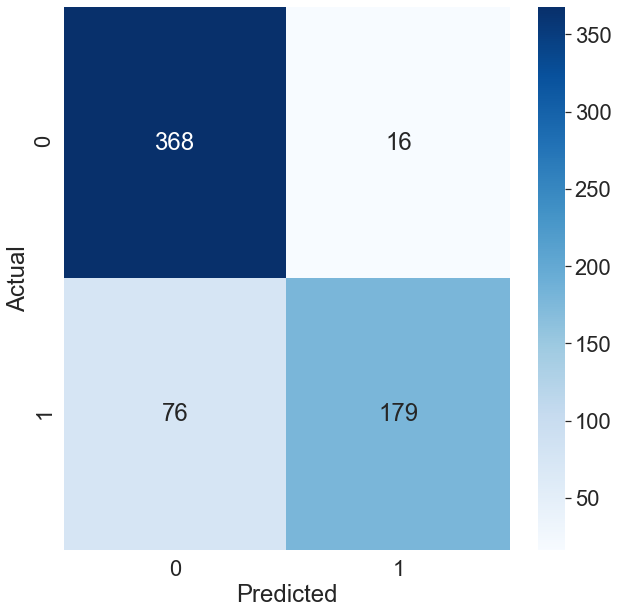

In [34]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

***

# IV. Company Classifier <a class="anchor" id="4"></a>

##  A. Constructing Training Set<a class="anchor" id="4A"></a>

This training set will contain the following columns: 
- **Relevant Entity (word)**
- **The first sentence of the corpus containing given entity (snippet)**
- **Features of the snippet above**
- **Label (Is it a Company?)**

And following types of samples
- Positive Samples
    - extracted from "labelled" data
- Negative Samples
    - extracted from the `spacy` package's algorithm, classified as `ORG`
    
    



### 1. Extracting Positive Samples <a class="anchor" id="4A1"></a>

Extracting only the entities in the labelled data that are present in the corpus, and storing it as a list in `company_inCorpus`

In [35]:
company_inCorpus = extract_ifInCorpus(companies)
company_inCorpus[:10]

100%|██████████| 2592/2592 [01:00<00:00, 42.80it/s]


['Toll Brothers',
 'Scribd',
 'Sprint Corp',
 'Altarum',
 'Autodesk',
 'Citigroup',
 'Ebay',
 'Costco Wholesale Corp',
 'Newman Corp',
 'Discover Financial Services Inc']

In [36]:
true_company = find_sentence(company_inCorpus, sentences)
true_company['Label'] = [1]*len(true_company)
true_company = true_company.rename(columns={"Word": "Organization", "Sentence": "Snippet"})
true_company.head(5)

100%|██████████| 2564/2564 [01:24<00:00, 30.42it/s]


,Organization,Snippet,Label
0,Toll Brothers,"I think multi-family construction has picked up if you listen to what Toll Brothers just said, t...",1
1,Scribd,"Search, &#8220;4 Justice Radio&#8221; on YouTube Video Search, &#8220;Veterans Foreclosures&#822...",1
2,Sprint Corp,3 ranked Sprint Corp promised big discounts for family and friend groups.,1
3,Altarum,"""Thats just surprisingly low,"" Charles Roerhig, director of the Altarum Institutes Center for Su...",1
4,Autodesk,"AutodeskAverage monthly base pay: $4,684 23.",1


In [37]:
len(true_company)

2560

2560 instances will be companies in the training set.

### 2. Extracting Negative Samples to Augment<a class="anchor" id="4A2"></a>

Extracting the first 3000 entities as `ORG` by Spacy NER algorithm but are not companies.

In [43]:
count = 0
# Empty DataFrame that will store "fake Company" entities from our corpus
fake_company = pd.DataFrame(columns=['Organization', 'Snippet', 'Label'])
for i in tqdm(range(len(org['Organization']))):
    # condition: if the entity is not a Company and it hasn't been already stored in the dataframe
    if (org.iloc[i]['Organization'] not in company_inCorpus) and (org.iloc[i]['Organization'] not in fake_company['Organization'].tolist()):
        # action: store the information about the entity in our dataframe
        fake_company = fake_company.append(org.iloc[i])
        count += 1
    # store the first 5002
    if count == 3000:
        break


  3%|▎         | 9047/320636 [00:08<05:05, 1018.33it/s]


Append `true_company` and `fake_company` to get a Full augmented dataframe of entities, its associated sentence, and the label. 

In [44]:
pd.options.display.max_colwidth = 1000
company_train = true_company.append(fake_company).reset_index(drop=True)
company_train = company_train.dropna()
company_train.head(10)
#pd.options.display.max_colwidth = 100

,Organization,Snippet,Label
0,Toll Brothers,"I think multi-family construction has picked up if you listen to what Toll Brothers just said, there's opportunities for apartment construction obviously in parts of New York, so when you look at Manhattan you get a very different picture than when you look elsewhere in the New York metro area.",1
1,Scribd,"Search, &#8220;4 Justice Radio&#8221; on YouTube Video Search, &#8220;Veterans Foreclosures&#8221; on Scribd, to read the complaintsummary.",1
2,Sprint Corp,3 ranked Sprint Corp promised big discounts for family and friend groups.,1
3,Altarum,"""Thats just surprisingly low,"" Charles Roerhig, director of the Altarum Institutes Center for Sustainable Health Spending, told the Kaiser Family Foundation.",1
4,Autodesk,"AutodeskAverage monthly base pay: $4,684 23.",1
5,Citigroup,"Citigroup is acting as financial advisor, and Kirkland &amp; Ellis LLP is acting as legal counsel, to Avis Budget Group.Morgan Stanley is acting as financial advisor, and Latham &amp; Watkins LLP is acting as legal counsel, to Zipcar.",1
6,Ebay,"I purchased this phone on Ebay and it came shiny and new in a white box, however the operating system was dodgy.",1
7,Costco Wholesale Corp,"Costco Wholesale Corp &lt;cost.o&gt; reported a better-than-expected 6 percent rise in comparable sales for the month, helped by strong sales of fresh food items and soft lines such as apparel, accessories and footwear.",1
8,Newman Corp,"Mr. Carlen carefully documents the returns earned in the ""Benjamin Graham Joint Account"" (the predecessor to Graham-Newman Corporation).",1
9,Discover Financial Services Inc,"(Reporting By Jessica Toonkel; Additional reporting by Ross Kerber and Sam Forgione; editing by Linda Stern and John Pickering) FREE AppDownloadWikimedia Commons(Reuters) - Discover Financial Services Inc sued Visa Inc on Tuesday, alleging the world's largest cards company has been using anti-competitive practices in its debit card business, and sought compensation for lost profit, court documents showed.",1


In [45]:
len(company_train)

5560

We will train our classifer algorithm on these 5560 samples (2560 true Companies, 3000 fake Companies.)

### 3. Building Features <a class="anchor" id="4A3"></a>

Based on the snippet, each sample will have five binary features that I believe are important in predicting that a given entity is a company. 

Features:
- `hasSuffix` Sentence has the words either Inc, Ltd, Co, LLC, Corp, Inc, or Group right after
- `hasQuarter` Sentence has the word Q1/2/3/4, quarter(s, ly, etc)
- `hasDollar` Sentence has the dollar sign \($\)
- `hasKeyword` Sentence has company-related keywords
- `numKeyword` Number of these keywords



In [47]:
# function to delete escape characters within regex patterns
def delete_Escape(w):
    new = ''.join( c for c in w if  c not in '.\\+*?[]$(){}=!<>|:-' )
    return new

def fill_hasSuffix(s, w):
    result = re.findall(fr'{delete_Escape(w)}\s(?:Ltd|Co|LLC|Corp|Group|Inc)(?:[^a-zA-Z]|$)', s) 
    #?: non-capturing groups, ensures the entire string is matched (not partially)
    if len(result) > 0:
        return 1
    else:
        return 0 
    
def fill_hasnumKeyword(s, ls):
    numKeyword = 0
    hasKeyword = 0
    for kw in ls:
        result = re.findall(fr'{delete_Escape(kw)}', s)
        numKeyword += len(result)
    if numKeyword > 0:
        hasKeyword = 1
    return hasKeyword, numKeyword
            

def fill_hasQuarter(s):
    result = re.findall(r'([Qq]uarter|Q[1234])', s)
    if len(result) > 0:
        return 1
    else:
        return 0 
    
def fill_hasDollar(s):
    result = re.findall(r'\$', s)
    if len(result) > 0:
        return 1
    else:
        return 0 


Adding these features to the training set

In [48]:
hasSuffix = []
hasKeyword = []
numKeyword = []
hasQuarter = []
hasDollar = []
keywords = ['Company','company','Companies', 'companies',
      'IPO', 'Stock','stock','Dividend','dividend',
      'CEO', 'President', 'president', 'chairman', 'Chairman']

for i in tqdm(range(len(company_train))):
    s = company_train['Snippet'][i]
    w = company_train['Organization'][i]
    hasSuffix.append(fill_hasSuffix(s, w))
    hasKeyword.append(fill_hasnumKeyword(s, keywords)[0])
    numKeyword.append(fill_hasnumKeyword(s, keywords)[1])
    hasQuarter.append(fill_hasQuarter(s))
    hasDollar.append(fill_hasDollar(s))
    

company_train['hasSuffix'] = hasSuffix
company_train['hasKeyword'] = hasKeyword
company_train['numKeyword'] = numKeyword
company_train['hasQuarter'] = hasQuarter
company_train['hasDollar'] = hasDollar



100%|██████████| 5560/5560 [00:01<00:00, 3641.42it/s]


### The training set for the Company Classifier

In [49]:
pd.options.display.max_colwidth = 100
company_train.head(20)


,Organization,Snippet,Label,hasSuffix,hasKeyword,numKeyword,hasQuarter,hasDollar
0,Toll Brothers,"I think multi-family construction has picked up if you listen to what Toll Brothers just said, t...",1,0,0,0,0,0
1,Scribd,"Search, &#8220;4 Justice Radio&#8221; on YouTube Video Search, &#8220;Veterans Foreclosures&#822...",1,0,0,0,0,0
2,Sprint Corp,3 ranked Sprint Corp promised big discounts for family and friend groups.,1,0,0,0,0,0
3,Altarum,"""Thats just surprisingly low,"" Charles Roerhig, director of the Altarum Institutes Center for Su...",1,0,0,0,0,0
4,Autodesk,"AutodeskAverage monthly base pay: $4,684 23.",1,0,0,0,0,1
5,Citigroup,"Citigroup is acting as financial advisor, and Kirkland &amp; Ellis LLP is acting as legal counse...",1,0,0,0,0,0
6,Ebay,"I purchased this phone on Ebay and it came shiny and new in a white box, however the operating s...",1,0,0,0,0,0
7,Costco Wholesale Corp,Costco Wholesale Corp &lt;cost.o&gt; reported a better-than-expected 6 percent rise in comparabl...,1,0,0,0,0,0
8,Newman Corp,"Mr. Carlen carefully documents the returns earned in the ""Benjamin Graham Joint Account"" (the pr...",1,0,0,0,0,0
9,Discover Financial Services Inc,(Reporting By Jessica Toonkel; Additional reporting by Ross Kerber and Sam Forgione; editing by ...,1,0,1,1,0,0


## B. Logistic Regression<a class="anchor" id="4B"></a>

I fit a logistic regression model on the training set and got a glimpse of the performance metrics.

In [50]:
X = company_train.iloc[:,3:]
y = company_train['Label'].astype('int')
# 80% train, 20% test 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state=42)
company_model = LogisticRegression(solver = 'lbfgs')
company_model.fit(X_train,y_train)
y_pred=company_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
metrics.recall_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.81      0.68       589
           1       0.64      0.38      0.48       523

    accuracy                           0.61      1112
   macro avg       0.62      0.59      0.58      1112
weighted avg       0.61      0.61      0.59      1112



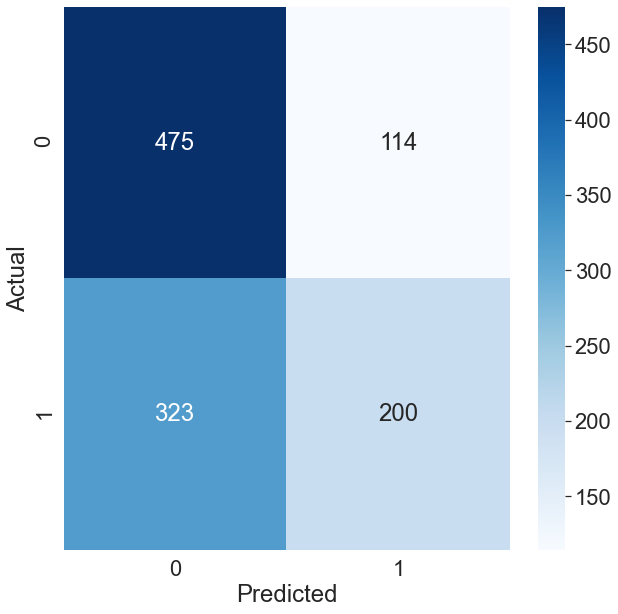

In [51]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

*** 

# V. Percentage Classifier <a class="anchor" id="5"></a>

##  A. Constructing Training Set<a class="anchor" id="5A"></a>

This training set will contain the following columns: 
- **Relevant Entity (word)**
- **The first sentence of the corpus containing given entity (snippet)**
- **Features of the snippet above**
- **Label (Is it a Percentage?)**

And following types of samples
- Positive Samples
    - extracted from "labelled" data
- Negative Samples
    - extracted from the `spacy` package's algorithm, classified as `CARDINAL`



### 1. Extracting Positive Samples <a class="anchor" id="5A1"></a>

Extracting only the entities in the labelled data that are present in the corpus, and storing it as a list in `percentage_inCorpus`

In [52]:
percentage_inCorpus = extract_ifInCorpus(percentage)

100%|██████████| 5377/5377 [01:29<00:00, 59.93it/s] 


In [54]:
true_percentage = find_sentence(percentage_inCorpus, sentences)
true_percentage['Label'] = [1]*len(true_percentage)
true_percentage = true_percentage.rename(columns={"Word": "Percentage", "Sentence": "Snippet"})
true_percentage.head(5)

100%|██████████| 4637/4637 [03:09<00:00, 24.46it/s]


,Percentage,Snippet,Label
0,66%,"Now that these payroll taxes are back, the US government can expect to collect revenue equivalen...",1
1,40%,"The Nasdaq is still down 40% from its high, and the Dow and S&amp;P 500 are essentially flat.",1
2,90%,"This would be USDJPY negative, but risk-correlated currencies now price in 80-90% probably of a ...",1
3,49%,"Here's the statement from Avis: PARSIPPANY, N.J. and CAMBRIDGE, Mass., Jan. 2, 2013 (GLOBE NEWSW...",1
4,100%,"They also think they have more leverage this time than they had over the Fiscal Cliff fight, sin...",1


### 2. Extracting Negative Samples to Augment <a class="anchor" id="5A2"></a>

In [58]:
count = 0
# Empty DataFrame that will store "fake Percentage" entities from our corpus
fake_percentage = pd.DataFrame(columns=['Percentage', 'Snippet', 'Label'])
for i in tqdm(range(len(cardinal['Percentage']))):
    # condition: if the entity is not a Percentage and it hasn't been already stored in the dataframe
    if (cardinal.iloc[i]['Percentage'] not in percentage_inCorpus) and (cardinal.iloc[i]['Percentage'] not in fake_percentage['Percentage'].tolist()):
        # action: store the information about the entity in our dataframe
        fake_percentage = fake_percentage.append(cardinal.iloc[i])
        count += 1
    # store the first 5000
    if count == 5000:
        break


 22%|██▏       | 28470/129885 [00:18<01:06, 1524.35it/s]


In [59]:
fake_percentage.head()

,Percentage,Snippet,Label
0,47.4,It just saw a rise in December PMI from 47.4 to 50.6.,0
2,50.1,From the report: The HSBC South Korea Purchasing Managers’ IndexTM (PMI®) – a composite indicato...,0
3,48.2,That was an improvement on November’s 48.2 and the highest reading since May.,0
4,50.0,"However, being barely above 50.0, the PMI suggested that operating conditions were little change...",0
5,one,"MarkitUPDATE: As the Fiscal Cliff bill gets closer to likely passage, the Aussie market (one of ...",0


Append `true_percentage` and `fake_percentage` to get a Full augmented dataframe of entities, its associated sentence, and the label. 

In [60]:
pd.options.display.max_colwidth = 1000
percentage_train = true_percentage.append(fake_percentage).reset_index(drop=True)
percentage_train = percentage_train.dropna()
percentage_train

,Percentage,Snippet,Label
0,66%,"Now that these payroll taxes are back, the US government can expect to collect revenue equivalent to about 0.66% of GDP, according to a report by UBS' global macro team.",1
1,40%,"The Nasdaq is still down 40% from its high, and the Dow and S&amp;P 500 are essentially flat.",1
2,90%,"This would be USDJPY negative, but risk-correlated currencies now price in 80-90% probably of a successful fix in our view, so the downside pressures will be large.",1
3,49%,"Here's the statement from Avis: PARSIPPANY, N.J. and CAMBRIDGE, Mass., Jan. 2, 2013 (GLOBE NEWSWIRE) -- Avis Budget Group, Inc. (Nasdaq:CAR) and Zipcar, Inc. (Nasdaq:ZIP), the world's leading car sharing network, today announced that Avis Budget Group has agreed to acquire Zipcar for $12.25 per share in cash, a 49% premium over the closing price on December 31, 2012, representing a total transaction value of approximately $500 million.",1
4,100%,"They also think they have more leverage this time than they had over the Fiscal Cliff fight, since taxes aren't about to rise on 100% of taxpayers.",1
...,...,...,...
8229,1255.70,Check with your broker....Gold was up 32.00 to 1255.70 (on Monday) and the whole gold universe closed higher.,0
8230,ten thousand,"When over ten thousand pigs collectively jumped into the Huangpu River, I realized that if I don’t believe in this “justice,” I’ll end up just like them.",0
8231,6.21,"The unfilled orders-to-shipments ratio was 6.21, down from 6.28 in April.",0
8232,6.28,"The unfilled orders-to-shipments ratio was 6.21, down from 6.28 in April.",0


In [61]:
len(percentage_train)

8234

We will train our classifer algorithm on these 8234 samples (3234 true Percentages, 5000 fake Percentages.)

### 3. Building Features<a class="anchor" id="5A3"></a>

Based on the snippet, each sample will have six binary features that I believe are important in predicting that a given entity is a "percentage."

Features:
- `hasPercentS` Has the symbol "%" following the entity in the sentence
- `hasPercentW` Has the word "percent" following the entity in the sentence
- `hasNumPercS` Extracted entity has the symbol % following a numerical character
- `hasNumPercW` Extracted entity has the word 'percent' following a numerical character 
- `hasWordPercS` Extracted entity has the symbol % following numerical words
- `hasNumPercW` Extracted entity has the word 'percent' following numerical words 


In [63]:

def fill_hasPercentS(s, w):
    result = re.findall(fr'{delete_Escape(w)}\s?%', s) 
    if len(result) > 0:
        return 1
    else:
        return 0  

def fill_hasPercentW(s, w):
    result = re.findall(fr'{delete_Escape(w)}\s?[Pp]ercent', s) 
    if len(result) > 0:
        return 1
    else:
        return 0 

def fill_hasNumPercS(w):
    result = re.findall(r'[0-9]\s?%', w)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasNumPercW(w):
    result = re.findall(r'[0-9]\s?[Pp]ercent', w)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasWordPercS(w):
    result = re.findall(r'(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|hundred|half|of a|quarter|teen|ty)\s?%', w)
    if len(result) > 0:
        return 1
    else:
        return 0 
def fill_hasWordPercW(w):
    result = re.findall(r'(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|hundred|half|of a|quarter|teen|ty)\s?[Pp]ercent', w)
    if len(result) > 0:
        return 1
    else:
        return 0 

In [64]:
hasPercentS = []
hasPercentW = []
hasNumPercS = []
hasNumPercW= []
hasWordPercS = []
hasWordPercW = []
# spacyLabel = []

for i in tqdm(range(len(percentage_train))):
    s = percentage_train['Snippet'][i]
    w = percentage_train['Percentage'][i]
    hasPercentS.append(fill_hasPercentS(s, w))
    hasPercentW.append(fill_hasPercentW(s, w))
    hasNumPercS.append(fill_hasNumPercS(w))
    hasNumPercW.append(fill_hasNumPercW(w))
    hasWordPercS.append(fill_hasWordPercS(w))
    hasWordPercW.append(fill_hasWordPercW(w))
#     spacyLabel.append(fill_spacyLabel(w))
    

percentage_train['hasPercentS'] = hasPercentS
percentage_train['hasPercentW'] = hasPercentW
percentage_train['hasNumPercS'] = hasNumPercS
percentage_train['hasNumPercW'] = hasNumPercW
percentage_train['hasWordPercS'] = hasWordPercS
percentage_train['hasWordPercW'] = hasWordPercW
# percentage_train['spacyLabel'] = spacyLabel


100%|██████████| 8234/8234 [00:01<00:00, 6295.47it/s]


### The training set for the Percentage Classifier

In [65]:
pd.options.display.max_colwidth = 100
percentage_train

,Percentage,Snippet,Label,hasPercentS,hasPercentW,hasNumPercS,hasNumPercW,hasWordPercS,hasWordPercW
0,66%,"Now that these payroll taxes are back, the US government can expect to collect revenue equivalen...",1,0,0,1,0,0,0
1,40%,"The Nasdaq is still down 40% from its high, and the Dow and S&amp;P 500 are essentially flat.",1,0,0,1,0,0,0
2,90%,"This would be USDJPY negative, but risk-correlated currencies now price in 80-90% probably of a ...",1,0,0,1,0,0,0
3,49%,"Here's the statement from Avis: PARSIPPANY, N.J. and CAMBRIDGE, Mass., Jan. 2, 2013 (GLOBE NEWSW...",1,0,0,1,0,0,0
4,100%,"They also think they have more leverage this time than they had over the Fiscal Cliff fight, sin...",1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
8229,1255.70,Check with your broker....Gold was up 32.00 to 1255.70 (on Monday) and the whole gold universe c...,0,0,0,0,0,0,0
8230,ten thousand,"When over ten thousand pigs collectively jumped into the Huangpu River, I realized that if I don...",0,0,0,0,0,0,0
8231,6.21,"The unfilled orders-to-shipments ratio was 6.21, down from 6.28 in April.",0,0,0,0,0,0,0
8232,6.28,"The unfilled orders-to-shipments ratio was 6.21, down from 6.28 in April.",0,0,0,0,0,0,0


## B. Logistic Regression<a class="anchor" id="5B"></a>

I fit a logistic regression model on the training set and got a glimpse of the performance metrics.

In [66]:
X = percentage_train.iloc[:,3:]
y = percentage_train['Label'].astype('int')
# 80% train, 20% test 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state=42)
percentage_model = LogisticRegression(solver = 'lbfgs')
percentage_model.fit(X_train,y_train)
y_pred=percentage_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
metrics.recall_score(y_test, y_pred)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.77      0.98      0.86       989
           1       0.95      0.56      0.71       658

    accuracy                           0.81      1647
   macro avg       0.86      0.77      0.78      1647
weighted avg       0.84      0.81      0.80      1647



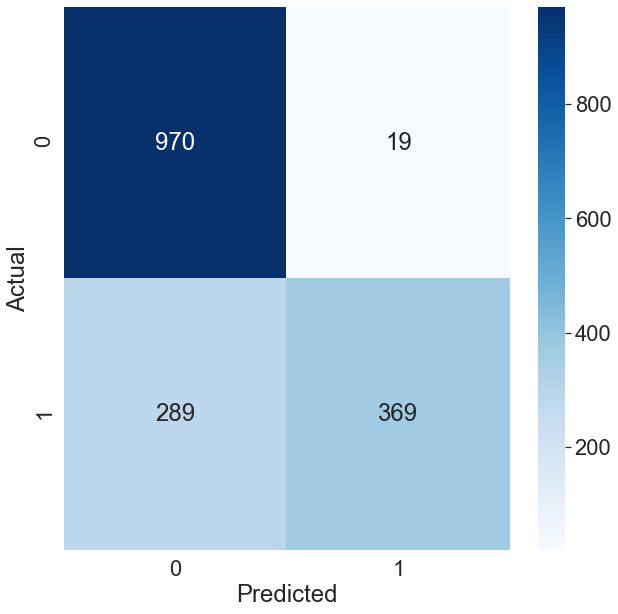

In [67]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# VI. Evaluation of Models <a class="anchor" id="6"></a>

In the building of the models above, I used positive samples and negative samples that were only a fraction of the words of interest that SpaCy detected in [Section II D.](#2D). The following code engineers the same features on the test sets created in [Section II D.](#2D), tests the respective classifier model, and evaluates them. 

Size of the respective test sets
- For the CEO classifier, there are 178642 entities to classify
- For the Company classifier, there are 320636 entities to classify
- For the Percentage classifier, there are 160896 entities to classify

Interpretation of the evaluation results can be found on **BI Text Classification Overview.ipynb**.

## A. CEO Classifier<a class="anchor" id="6A"></a>

Engineering features for the CEO test set

In [69]:
person_result = person.copy()

hasCEO = []
hasPres = []
hasChairman = []
hasChiefExec = []
hasFounder = []
hasPossession = []

# Building Features
for i in tqdm(range(len(person_result))):
    s = person_result['Snippet'][i]
    w = person_result['Person'][i]
    hasCEO.append(fill_hasCEO(s))
    hasPres.append(fill_hasPres(s))
    hasChairman.append(fill_hasChairman(s))
    hasChiefExec.append(fill_hasChiefExec(s))
    hasFounder.append(fill_hasFounder(s))
    hasPossession.append(fill_hasPossession(s, w))

# Creating DataFrame
person_result['hasCEO'] = hasCEO
person_result['hasPres'] = hasPres
person_result['hasChairman'] = hasChairman
person_result['hasChiefExec'] = hasChiefExec
person_result['hasFounder'] = hasFounder
person_result['hasPossession'] = hasPossession

pd.options.display.max_colwidth = 100

person_result

100%|██████████| 178642/178642 [00:11<00:00, 16118.11it/s]


,Person,Snippet,Label,hasCEO,hasPres,hasChairman,hasChiefExec,hasFounder,hasPossession
0,Mitch McConnell,From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by...,0,0,0,0,0,0,0
1,John Boehner,From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by...,0,0,0,0,0,0,0
2,Drudge Report,Here's the banner leading Drudge Report right now: Drudge ReportGood news for the global economy.,0,0,0,0,0,0,0
3,Drudge ReportGood,Here's the banner leading Drudge Report right now: Drudge ReportGood news for the global economy.,0,0,0,0,0,0,0
4,Aussie,"MarkitUPDATE: As the Fiscal Cliff bill gets closer to likely passage, the Aussie market (one of ...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
178637,Ed Morse,"""In practice this long-awaited move can open up the floodgates to substantial increases in expor...",0,0,0,0,0,0,0
178638,Kevin Book,"The document gives ""considerable discretion"" that could allow for rising export volumes in the f...",0,0,0,0,0,0,0
178639,Jason Bordoff,"""Whether to allow crude oil exports directly because the production of light crude overwhelms th...",0,0,0,0,0,0,0
178640,Jonathan Leff,(Reporting by Jonathan Leff; Editing by Steve Orlofsky) FREE AppDownload,0,0,0,0,0,0,0


Applying model

In [70]:
person_result_X = person_result.iloc[:,3:]
person_result_y = ceo_model.predict(person_result_X)
person_result['Decision'] = person_result_y

**Results**

In [71]:
print(classification_report(person_result['Label'], person_result['Decision']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    165567
           1       0.32      0.31      0.32     13075

    accuracy                           0.90    178642
   macro avg       0.63      0.63      0.63    178642
weighted avg       0.90      0.90      0.90    178642



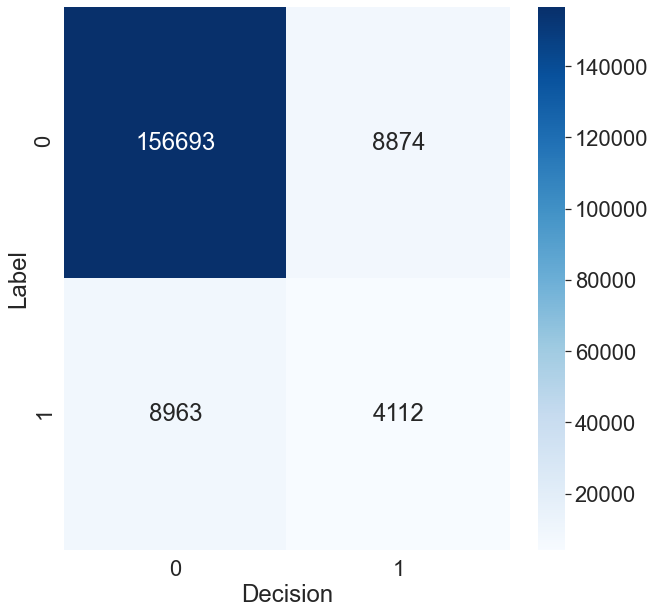

In [72]:
confusion_matrix = pd.crosstab(person_result['Label'], person_result['Decision'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

Storing entities predicted to be CEOs by the model

In [78]:
ceo_predicted = person_result[person_result['Decision']==1][['Person']].reset_index(drop=True)
ceo_predicted

,Person
0,William D. Cohan's
1,Jimmy Cayne
2,Bill Gross
3,Wien
4,Jeff Immelt
...,...
12981,Heather Cho
12982,Jim Paulsen
12983,Tobias Levkovich
12984,Mike O'Rourke


In [79]:
ceo_predicted.to_csv('ceo_predicted.csv')

## B. Company Classifier<a class="anchor" id="6B"></a>

Engineering features for the Company Test Set

In [81]:
org_result = org.copy()
org_result = org_result.dropna()
org_result['Snippet'] = org_result['Snippet'].astype(str)
org_result = org_result.drop(org_result.index[10624]).reset_index(drop=True)


hasSuffix = []
hasKeyword = []
numKeyword = []
# hasCompany = []
# hasStock = []
# hasIPO = []
# hasDividend = []
hasQuarter = []
hasDollar = []
keywords = ['Company','company','Companies', 'companies',
      'IPO', 'Stock','stock','Dividend','dividend',
      'CEO', 'President', 'president', 'chairman', 'Chairman']

for i in tqdm(range(len(org_result))):
    s = org_result['Snippet'][i]
    w = org_result['Organization'][i]
    hasSuffix.append(fill_hasSuffix(s, w))
    hasKeyword.append(fill_hasnumKeyword(s, keywords)[0])
    numKeyword.append(fill_hasnumKeyword(s, keywords)[1])
#     hasCompany.append(fill_hasCompany(s))
#     hasStock.append(fill_hasStock(s))
#     hasIPO.append(fill_hasIPO(s))
#     hasDividend.append(fill_hasDividend(s))
    hasQuarter.append(fill_hasQuarter(s))
    hasDollar.append(fill_hasDollar(s))
    

org_result['hasSuffix'] = hasSuffix
# company_train['hasCompany'] = hasCompany
# company_train['hasStock'] = hasStock
# company_train['hasIPO'] = hasIPO
# company_train['hasDividend'] = hasDividend
org_result['hasKeyword'] = hasKeyword
org_result['numKeyword'] = numKeyword
org_result['hasQuarter'] = hasQuarter
org_result['hasDollar'] = hasDollar

pd.options.display.max_colwidth = 100

org_result

100%|██████████| 320635/320635 [00:53<00:00, 6040.49it/s]


,Organization,Snippet,Label,hasSuffix,hasKeyword,numKeyword,hasQuarter,hasDollar
0,PMI,Earlier today we had a strong South Korean PMI report.,0,0,0,0,0,0
1,PMI,It just saw a rise in December PMI from 47.4 to 50.6.,0,0,0,0,0,0
2,House,From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by...,0,0,0,0,0,0
3,Senate,From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by...,0,0,0,0,0,0
4,the White House,From the report: With the House prepared to vote on the Senate fiscal cliff bill orchestrated by...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
320630,Brent/WTI,"On Tuesday, the Brent/WTI spread narrowed by more than 50 cents to around $3.70 a barrel.",0,0,0,0,0,1
320631,BIS,"In its guidelines, the BIS said that most goods can be shipped abroad ""without a license"" - a re...",0,0,0,0,0,0
320632,Reuters,"In its guidelines, the BIS said that most goods can be shipped abroad ""without a license"" - a re...",1,0,0,0,0,0
320633,Columbia University's Center on Global Energy Policy,"""Whether to allow crude oil exports directly because the production of light crude overwhelms th...",0,0,0,0,0,0


Applying model

In [82]:
org_result_X = org_result.iloc[:,3:]
org_result_y = company_model.predict(org_result_X)
org_result['Decision'] = org_result_y

**Results**

In [83]:
print(classification_report(org_result['Label'], org_result['Decision']))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81    247151
           1       0.30      0.23      0.26     73484

    accuracy                           0.70    320635
   macro avg       0.54      0.53      0.53    320635
weighted avg       0.67      0.70      0.68    320635



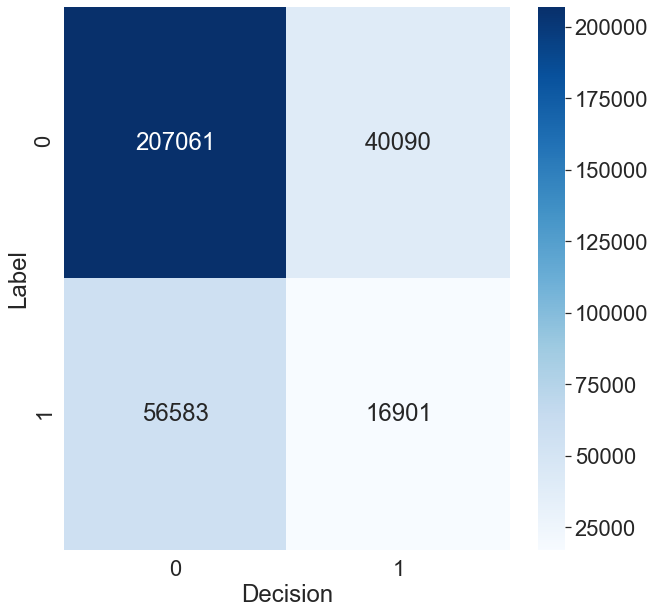

In [84]:
confusion_matrix = pd.crosstab(org_result['Label'], org_result['Decision'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

Storing entities predicted to be companies by the model

In [85]:
companies_predicted = org_result[org_result['Decision']==1][['Organization']].reset_index(drop=True)
companies_predicted

,Organization
0,Senate
1,Senate
2,Mitt Romney
3,Fiscal Cliff
4,Obamacare
...,...
56986,Reuters
56987,BIS
56988,Pioneer Natural Resources
56989,Enterprise Products Partners


In [86]:
companies_predicted.to_csv('companies_predicted.csv')

## C. Percentage Classifier<a class="anchor" id="6C"></a>

Creating Percentage Test Set
- I created dataframes for entities classified as `CARDINAL` and `PERCENT`
    - `PERCENT` refers to those classified as percentages (mostly positive samples)
    - `CARDINAL` refers to other numeric values that do not fall under a specific type. (mostsly negative samples)
- I appended `percent` and `cardinal` and engineered features to create the test set.

In [ ]:
percent['Label'] = [np.int64(1)]*len(percent) 
# from the cardinal dataframe, subsetting smples of "cardinals" that are negative samples.
cardinal_notperc = pd.DataFrame(columns=['Percentage', 'Snippet', 'Label'])
for i in tqdm(range(len(cardinal))):
    if cardinal.iloc[i]['Percentage'] not in percentage_inCorpus:
        cardinal_notperc = cardinal_notperc.append(cardinal.iloc[i])   
cardinal_notperc = cardinal_notperc.reset_index(drop=True)

# appending percent and cardinal to create test set
percent_result = percent.append(cardinal_notperc).reset_index(drop=True)
percent_result = percent_result.dropna()
percent_result['Snippet'] = percent_result['Snippet'].astype(str)

Engineering Features for the Percentage test set

In [92]:
hasPercentS = []
hasPercentW = []
hasNumPercS = []
hasNumPercW= []
hasWordPercS = []
hasWordPercW = []

for i in tqdm(range(len(percent_result))):
    s = percent_result['Snippet'][i]
    w = percent_result['Percentage'][i]
    hasPercentS.append(fill_hasPercentS(s,w))
    hasPercentW.append(fill_hasPercentW(s,w))
    hasNumPercS.append(fill_hasNumPercS(w))
    hasNumPercW.append(fill_hasNumPercW(w))
    hasWordPercS.append(fill_hasWordPercS(w))
    hasWordPercW.append(fill_hasWordPercW(w))
    

percent_result['hasPercentS'] = hasPercentS
percent_result['hasPercentW'] = hasPercentW
percent_result['hasNumPercS'] = hasNumPercS
percent_result['hasNumPercW'] = hasNumPercW
percent_result['hasWordPercS'] = hasWordPercS
percent_result['hasWordPercW'] = hasWordPercW

pd.options.display.max_colwidth = 100

percent_result

100%|██████████| 160896/160896 [00:14<00:00, 11312.84it/s]


,Percentage,Snippet,Label,hasPercentS,hasPercentW,hasNumPercS,hasNumPercW,hasWordPercS,hasWordPercW
0,1.2%,Hong Kong is up over 1.2%.,1,0,0,1,0,0,0
1,39.6%,"And income taxes will only rise for households making a healthy $450,000 or more--and, even then...",1,0,0,1,0,0,0
2,47%,Congress just socked it to Mitt Romney's famous 47%.,1,0,0,1,0,0,0
3,47%,"Remember ""the 47%""?",1,0,0,1,0,0,0
4,4.2%,So there's great news for these folks tucked into the Senate bill: By not extending the payroll ...,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
160891,two,"If they can boost selling prices by even a dollar or two, oil producers in places such as the Ea...",0,0,0,0,0,0,0
160892,"200,000","Morse said U.S. condensate exports could rise from 200,000 bpd to as much as 1 million bpd by th...",0,0,0,0,0,0,0
160893,Two,"Two energy companies, driller Pioneer Natural Resources and mid-stream firm Enterprise Products ...",0,0,0,0,0,0,0
160894,several dozen,"But several dozen other companies that also raced to file similar requests were left waiting, wi...",0,0,0,0,0,0,0


Applying Model

In [93]:
percent_result_X = percent_result.iloc[:,3:]
percent_result_y = percentage_model.predict(percent_result_X)
percent_result['Decision'] = percent_result_y
percent_result['Label'] = percent_result['Label'].astype(np.int64)

**Results**

In [95]:
print(classification_report(percent_result['Label'], percent_result['Decision']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87782
           1       0.99      1.00      1.00     73114

    accuracy                           1.00    160896
   macro avg       1.00      1.00      1.00    160896
weighted avg       1.00      1.00      1.00    160896



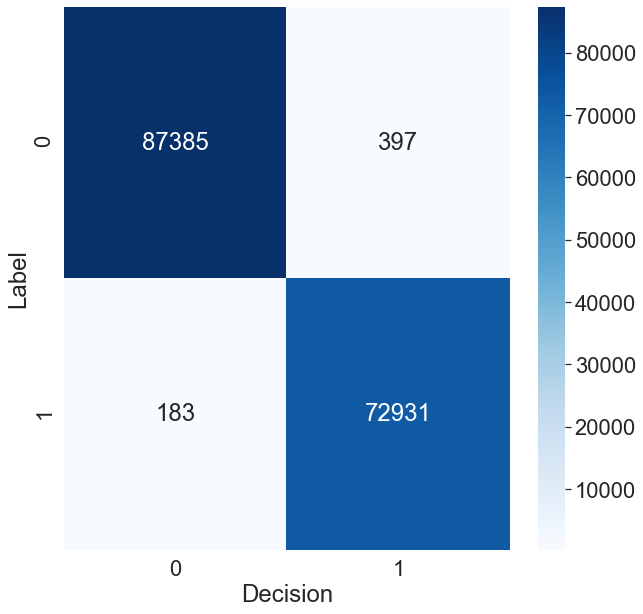

In [96]:
confusion_matrix = pd.crosstab(percent_result['Label'], percent_result['Decision'])
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

Storing entities predicted to be percentages by the model

In [97]:
percentages_predicted = percent_result[percent_result['Decision']==1][['Percentage']].reset_index(drop=True)
percentages_predicted

,Percentage
0,1.2%
1,39.6%
2,47%
3,47%
4,4.2%
...,...
73323,35%+
73324,45%against
73325,15-16%-a
73326,between 1 and 9%


In [98]:
percentages_predicted.to_csv('percentages_predicted.csv')